<a href="https://colab.research.google.com/github/uditmanav17/DL-with-Python/blob/master/Ch%208.2-3%3A%20Generative%20DL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 8.2 Deep Dream
[DeepDream](https://ai.googleblog.com/2015/07/deepdream-code-example-for-visualizing.html) is an artistic image-modification technique that uses the representations learned by convolutional neural networks. It was first released by Google in the summer of 2015. 

Let's try to implement it.

In [1]:
from keras.applications import inception_v3
from keras import backend as K

# since we won't be doing any training, 
# this is used to disable all reaining specific operatiosn
K.set_learning_phase(0)

model = inception_v3.InceptionV3(weights='imagenet', include_top=False)
model.summary()

Using TensorFlow backend.


87916544/87910968 [==============================] - 3s 0us/step
Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, None, None, 3 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, None, None, 3 0           batch_normalization_1[0][0]      
______________________

Here, you’ll simultaneously maximize the activation of all filters in a number of layers. Specifically, you’ll maximize a weighted sum of the L2 norm of the activations of a set of high-level layers. The exact set of layers you choose (as well as their contribution to the final loss) has a major influence on the visuals you’ll be able to produce, so you want to make these parameters easily configurable. Lower layers result in geometric patterns, whereas higher layers result in visuals in which you can recognize some classes from ImageNet (for example, birds or dogs). You’ll start from a somewhat arbitrary configuration involving four layers—but you’ll definitely want to explore many different configurations later.

In [2]:
# Dictionary mapping layer names to a coefficient quantifying how much the 
# layer’s activation contributes to the loss you’ll seek to maximize. 
# Note that the layer names are hardcoded in the built-in Inception V3 application. 

layer_contributions = {
    'mixed2': 0.2,
    'mixed3': 3.,
    'mixed4': 2.,
    'mixed5': 1.5,
}

In [3]:
# Creates a dictionary that maps layer names to layer instances
layer_dict = dict([(layer.name, layer) for layer in model.layers])
print(layer_dict)

{'input_1': <keras.engine.input_layer.InputLayer object at 0x7ff708462f60>, 'conv2d_1': <keras.layers.convolutional.Conv2D object at 0x7ff6c6165c88>, 'batch_normalization_1': <keras.layers.normalization.BatchNormalization object at 0x7ff6c6165e48>, 'activation_1': <keras.layers.core.Activation object at 0x7ff6c6165f60>, 'conv2d_2': <keras.layers.convolutional.Conv2D object at 0x7ff72453ea58>, 'batch_normalization_2': <keras.layers.normalization.BatchNormalization object at 0x7ff6c065a630>, 'activation_2': <keras.layers.core.Activation object at 0x7ff6c065a940>, 'conv2d_3': <keras.layers.convolutional.Conv2D object at 0x7ff6c0671da0>, 'batch_normalization_3': <keras.layers.normalization.BatchNormalization object at 0x7ff6c0604b38>, 'activation_3': <keras.layers.core.Activation object at 0x7ff6c0604e48>, 'max_pooling2d_1': <keras.layers.pooling.MaxPooling2D object at 0x7ff6c0671d30>, 'conv2d_4': <keras.layers.convolutional.Conv2D object at 0x7ff6c06142b0>, 'batch_normalization_4': <keras

In [5]:
# DEFINING LOSS TO BE MAXIMIZED

# define loss by adding layer contribution to this scalar
loss = K.variable(0.)

for layer_name in layer_contributions:
    coeff = layer_contributions[layer_name]
    
    # get layer outputs
    activation = layer_dict[layer_name].output
    scaling = K.prod(K.cast(K.shape(activation), 'float32'))

    # Adds the L2 norm of the features of a layer to the loss. 
    # You avoid border artifacts by only involving nonborder pixels in the loss.
    loss = loss + coeff * K.sum(K.square(activation[:, 2: -2, 2: -2, :])) / scaling

In [6]:
# GRADIENT ASCENT PROCESS

# tensor holding generated image
dream = model.input

# Computes the gradients of the dream with regard to the loss
grads = K.gradients(loss, dream)[0]

# IMPORTANT: Normalize the gradients
grads /= K.maximum(K.mean(K.abs(grads)), 1e-7)

# Sets up a Keras function to retrieve the value of
# the loss and gradients, given an input image
outputs = [loss, grads]
fetch_loss_and_grads = K.function([dream], outputs)

In [7]:
def eval_loss_and_grads(x):
    outs = fetch_loss_and_grads([x])
    loss_value = outs[0]
    grad_values = outs[1]
    return loss_value, grad_values

# this function runs gradient ascent for a number of iterations
def gradient_ascent(x, iterations, step, max_loss=None):
    for i in range(iterations):
        loss_value, grad_values = eval_loss_and_grads(x)
        if max_loss is not None and loss_value > max_loss:
            break
        print('...Loss value at', i, ':', loss_value)
        x += step * grad_values
    return x

Finally: the actual DeepDream algorithm. First, you define a list of scales (also called octaves) at which to process the images. Each successive scale is larger than the previous one by a factor of 1.4 (it’s 40% larger): you start by processing a small image and then increasingly scale it up.

For each successive scale, from the smallest to the largest, you run gradient ascent to maximize the loss you previously defined, at that scale. After each gradient ascent run, you upscale the resulting image by 40%.

To avoid losing a lot of image detail after each successive scale-up (resulting in increasingly blurry or pixelated images), you can use a simple trick: after each scaleup, you’ll reinject the lost details back into the image, which is possible because you know what the original image should look like at the larger scale. Given a small image size S and a larger image size L, you can compute the difference between the original image resized to size L and the original resized to size S —this difference quantifies the details lost when going from S to L.

In [25]:
# Some Auxillary functions
import scipy
import scipy.misc
import imageio
from keras.preprocessing import image

def resize_img(img, size):
    img = np.copy(img)
    factors = (1,    
               float(size[0]) / img.shape[1],    
               float(size[1]) / img.shape[2],    
               1)
    return scipy.ndimage.zoom(img, factors, order=1)

def save_img(img, fname):
    pil_img = deprocess_image(np.copy(img))
    imageio.imwrite(fname, pil_img)
    # scipy.misc.imsave(fname, pil_img)

def preprocess_image(image_path):
    img = image.load_img(image_path)
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = inception_v3.preprocess_input(img)
    return img

# convert tensor into valid image
def deprocess_image(x):
    if K.image_data_format() == 'channels_first':
        x = x.reshape((3, x.shape[2], x.shape[3]))
        x = x.transpose((1, 2, 0))
    else:
        # Undoes preprocessing that was performed by inception_v3.preprocess_input
        x = x.reshape((x.shape[1], x.shape[2], 3))
    x /= 2.
    x += 0.5
    x *= 255.
    x = np.clip(x, 0, 255).astype('uint8')
    return x    

In [83]:
# Running gradient ascent over different successive scales

import numpy as np

# change these for varied effects
step = 0.01  # gradient ascent step size
num_octave = 3  # number of scales at which to run gradient ascent
octave_scale = 1.4  # size ratio b/w scales
iterations = 1000

# If the loss grows larger than 10, you’ll interrupt
# the gradient-ascent process to avoid ugly artifacts
max_loss = 1e100  # 10.

# image path
base_image_path = './plain.jpg'
img = preprocess_image(base_image_path)  # loads image to numpy array 

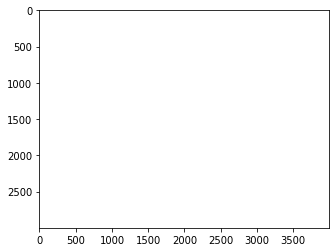

In [84]:
import matplotlib.pyplot as plt

plt.imshow(np.squeeze(img))

In [85]:
original_shape = img.shape[1:3]
# Prepares a list of shape tuples defining the different scales at which to run gradient ascent
successive_shapes = [original_shape]
for i in range(1, num_octave):
    shape = tuple([int(dim / (octave_scale ** i)) for dim in original_shape])
    successive_shapes.append(shape)

# Reverses the list of shapes so they’re in increasing order
successive_shapes = successive_shapes[::-1]

successive_shapes

[(1530, 2040), (2142, 2857), (3000, 4000)]

In [86]:
# Resizes the Numpy array of the image to the smallest scale
original_img = np.copy(img)
shrunk_original_img = resize_img(img, successive_shapes[0])
shrunk_original_img.shape

(1, 1530, 2040, 3)

In [ ]:
for shape in successive_shapes:
    print('Processing image shape', shape)
    # scale up the dream image
    img = resize_img(img, shape)
    # run gradient ascent, altering the dream
    img = gradient_ascent(img,
                          iterations=iterations,    
                          step=step,    
                          max_loss=max_loss)
    # scale up the smaller version of the original image
    upscaled_shrunk_original_img = resize_img(shrunk_original_img, shape)
    # compute the high-quality version of original image
    same_size_original = resize_img(original_img, shape)
    # difference between the two is the detail that was lost when scaling up.
    lost_detail = same_size_original - upscaled_shrunk_original_img
    
    img += lost_detail  # reinsert lost details into image
    shrunk_original_img = resize_img(original_img, shape)
    save_img(img, fname='dream_at_scale_' + str(shape) + '.png')

save_img(img, fname='final_dream.png')

In [77]:
# remove all generate images
!rm *.png

## 8.3 Neural Style Transfer
The [neural style transfer](https://arxiv.org/abs/1508.06576) algorithm has undergone many refinements and spawned many variations since its original introduction, and it has made its way into many smartphone photo apps. It  consists of applying the style of a reference image to a target image while conserving the content of the target image.

In this context, style essentially means textures, colors, and visual patterns in the image, at various spatial scales; and the content is the higher-level macrostructure of the image.

The key notion behind implementing style transfer is the same idea that’s central to all deep-learning algorithms: you define a loss function to specify what you want to achieve, and you minimize this loss. You know what you want to achieve: conserving the content of the original image while adopting the style of the reference image. If we were able to mathematically define content and style, then an appropriate loss function to minimize would be the following:
```Python
loss = distance(style(reference_image) - style(generated_image)) +
distance(content(original_image) - content(generated_image))
```

Here, distance is a norm function such as the L2 norm, content is a function that takes an image and computes a representation of its content, and style is a function that takes an image and computes a representation of its style. Minimizing this loss causes style(generated_image) to be close to style(reference_image), and content(generated_image) is close to content(generated_image), thus achieving style transfer as we defined it.

### 8.3.1 The Content Loss

As you already know, activations from earlier layers in a network contain local information about the image, whereas activations from higher layers contain increasingly global, abstract information. Formulated in a different way, the activations of the different layers of a convnet provide a decomposition of the contents of an image over different spatial scales. Therefore, you’d expect the content of an image, which is more global and abstract, to be captured by the representations of the upper layers in a convnet.

A good candidate for content loss is thus the L2 norm between the activations of an upper layer in a pretrained convnet, computed over the target image, and the activations of the same layer computed over the generated image. This guarantees that, as seen from the upper layer, the generated image will look similar to the original target image. Assuming that what the upper layers of a convnet see is really the content of their input images, then this works as a way to preserve image content.

### 8.3.2 The Style Loss

The content loss only uses a single upper layer, but the style loss as defined by Gatys et al. uses multiple layers of a convnet: you try to capture the appearance of the stylereference image at all spatial scales extracted by the convnet, not just a single scale. For the style loss, Gatys et al. use the Gram matrix of a layer’s activations: the inner product of the feature maps of a given layer. This inner product can be understood as representing a map of the correlations between the layer’s features. These feature correlations capture the statistics of the patterns of a particular spatial scale, which empirically correspond to the appearance of the textures found at this scale.

Hence, the style loss aims to preserve similar internal correlations within the activations of different layers, across the style-reference image and the generated image. In turn, this guarantees that the textures found at different spatial scales look similar across the style-reference image and the generated image.

In short, you can use a pretrained convnet to define a loss that will do the following:
* Preserve content by maintaining similar high-level layer activations between the target content image and the generated image. The convnet should “see” both the target image and the generated image as containing the same things.
* Preserve style by maintaining similar correlations within activations for both lowlevel layers and high-level layers. Feature correlations capture textures: the generated image and the style-reference image should share the same textures at different spatial scales.

### 8.3.3 Style Transfer Implementation in Keras
Neural style transfer can be implemented using any pretrained convnet. We'll use the VGG19 network. It is a simple variant of the VGG16 network, with three more convolutional layers.
This is the general process:
1. Set up a network that computes VGG19 layer activations for the style-reference image, the target image, and the generated image at the same time.
2. Use the layer activations computed over these three images to define the loss function described earlier, which you’ll minimize in order to achieve style transfer.
3. Set up a gradient-descent process to minimize this loss function.

Let’s start by defining the paths to the style-reference image and the target image. To make sure that the processed images are a similar size (widely different sizes make style transfer more difficult), you’ll later resize them all to a shared height of 400 px.

In [89]:
# Auxillary Functions
import numpy as np
from keras.applications import vgg19

def preprocess_image(image_path):
    img = load_img(image_path, target_size=(img_height, img_width))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = vgg19.preprocess_input(img)
    return img

def deprocess_image(x):
    # Remove zero-center by mean pixel
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    # 'BGR'->'RGB'
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [90]:
from keras.preprocessing.image import load_img, img_to_array

# This is the path to the image you want to transform.
target_image_path = './me.jpg'
# This is the path to the style image.
style_reference_image_path = './the_starry_night-wallpaper-2560x1440.jpg'

# Dimensions of the generated picture.
width, height = load_img(target_image_path).size
img_height = 400
img_width = int(width * img_height / height)

Let's set up the VGG19 network. It takes as input a batch of three images: the style reference image, the target image, and a placeholder that will contain the generated image. A placeholder is simply a symbolic tensor, the values of which are provided externally via Numpy arrays. The style reference and target image are static, and thus defined using K.constant, while the values contained in the placeholder of the generated image will change over time.

In [91]:
from keras import backend as K

target_image = K.constant(preprocess_image(target_image_path))
style_reference_image = K.constant(preprocess_image(style_reference_image_path))

# This placeholder will contain our generated image
combination_image = K.placeholder((1, img_height, img_width, 3))

# We combine the 3 images into a single batch
input_tensor = K.concatenate([target_image,
                              style_reference_image,
                              combination_image], axis=0)

# We build the VGG19 network with our batch of 3 images as input.
# The model will be loaded with pre-trained ImageNet weights.
model = vgg19.VGG19(input_tensor=input_tensor,
                    weights='imagenet',
                    include_top=False)
print('Model loaded.')

80142336/80134624 [==============================] - 2s 0us/step
Model loaded.


In [92]:
# Content Loss
def content_loss(base, combination):
    return K.sum(K.square(combination - base))

# Style Loss -  leverages an auxiliary function to compute the Gram matrix 
# of an input matrix, i.e. a map of the correlations found in the original feature matrix.    
def gram_matrix(x):
    features = K.batch_flatten(K.permute_dimensions(x, (2, 0, 1)))
    gram = K.dot(features, K.transpose(features))
    return gram


def style_loss(style, combination):
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = img_height * img_width
    return K.sum(K.square(S - C)) / (4. * (channels ** 2) * (size ** 2))

To these two loss components, we add a third one, the "total variation loss". It is meant to encourage spatial continuity in the generated image, thus avoiding overly pixelated results. You could interpret it as a regularization loss.

In [93]:
def total_variation_loss(x):
    a = K.square(
        x[:, :img_height - 1, :img_width - 1, :] - x[:, 1:, :img_width - 1, :])
    b = K.square(
        x[:, :img_height - 1, :img_width - 1, :] - x[:, :img_height - 1, 1:, :])
    return K.sum(K.pow(a + b, 1.25))

The loss that we minimize is a weighted average of these three losses. To compute the content loss, we only leverage one top layer, the block5_conv2 layer, while for the style loss we use a list of layers than spans both low-level and high-level layers. We add the total variation loss at the end.

Depending on the style reference image and content image you are using, you will likely want to tune the content_weight coefficient, the contribution of the content loss to the total loss. A higher content_weight means that the target content will be more recognizable in the generated image.


In [95]:
# Dict mapping layer names to activation tensors
outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])
# Name of layer used for content loss
content_layer = 'block5_conv2'
# Name of layers used for style loss
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1',
                'block4_conv1',
                'block5_conv1']
# Weights in the weighted average of the loss components
total_variation_weight = 1e-4
style_weight = 1.
content_weight = 0.025

# Define the loss by adding all components to a `loss` variable
loss = K.variable(0.)
layer_features = outputs_dict[content_layer]
target_image_features = layer_features[0, :, :, :]
combination_features = layer_features[2, :, :, :]
loss = loss + content_weight * content_loss(target_image_features,
                                      combination_features)
for layer_name in style_layers:
    layer_features = outputs_dict[layer_name]
    style_reference_features = layer_features[1, :, :, :]
    combination_features = layer_features[2, :, :, :]
    sl = style_loss(style_reference_features, combination_features)
    loss = loss + (style_weight / len(style_layers)) * sl
loss = loss + total_variation_weight * total_variation_loss(combination_image)



Finally, we set up the gradient descent process. In the original Gatys et al. paper, optimization is performed using the L-BFGS algorithm, so that is also what we will use here. This is a key difference from the Deep Dream example in the previous section. The L-BFGS algorithms comes packaged with SciPy. However, there are two slight limitations with the SciPy implementation:

* It requires to be passed the value of the loss function and the value of the gradients as two separate functions.
* It can only be applied to flat vectors, whereas we have a 3D image array.

It would be very inefficient for us to compute the value of the loss function and the value of gradients independently, since it would lead to a lot of redundant computation between the two. We would be almost twice slower than we could be by computing them jointly. To by-pass this, we set up a Python class named Evaluator that will compute both loss value and gradients value at once, will return the loss value when called the first time, and will cache the gradients for the next call.


In [96]:
# Get the gradients of the generated image wrt the loss
grads = K.gradients(loss, combination_image)[0]

# Function to fetch the values of the current loss and the current gradients
fetch_loss_and_grads = K.function([combination_image], [loss, grads])


class Evaluator(object):

    def __init__(self):
        self.loss_value = None
        self.grads_values = None

    def loss(self, x):
        assert self.loss_value is None
        x = x.reshape((1, img_height, img_width, 3))
        outs = fetch_loss_and_grads([x])
        loss_value = outs[0]
        grad_values = outs[1].flatten().astype('float64')
        self.loss_value = loss_value
        self.grad_values = grad_values
        return self.loss_value

    def grads(self, x):
        assert self.loss_value is not None
        grad_values = np.copy(self.grad_values)
        self.loss_value = None
        self.grad_values = None
        return grad_values

evaluator = Evaluator()

In [ ]:
# Finally, we can run the gradient ascent process using SciPy's L-BFGS algorithm, 
# saving the current generated image at each iteration of the algorithm 
# (here, a single iteration represents 20 steps of gradient ascent):

from scipy.optimize import fmin_l_bfgs_b
# from scipy.misc import imsave
import imageio
import time

result_prefix = 'style_transfer_result'
iterations = 200

# Run scipy-based optimization (L-BFGS) over the pixels of the generated image
# so as to minimize the neural style loss.
# This is our initial state: the target image.
# Note that `scipy.optimize.fmin_l_bfgs_b` can only process flat vectors.
x = preprocess_image(target_image_path)
x = x.flatten()
for i in range(iterations):
    print('Start of iteration', i)
    start_time = time.time()
    x, min_val, info = fmin_l_bfgs_b(evaluator.loss, x,
                                     fprime=evaluator.grads, maxfun=20)
    print('Current loss value:', min_val)
    # Save current generated image
    img = x.copy().reshape((img_height, img_width, 3))
    img = deprocess_image(img)
    fname = result_prefix + '_at_iteration_%d.png' % i
    imageio.imwrite(fname, img)
    # imsave(fname, img)
    end_time = time.time()
    print('Image saved as', fname)
    print('Iteration %d completed in %ds' % (i, end_time - start_time))

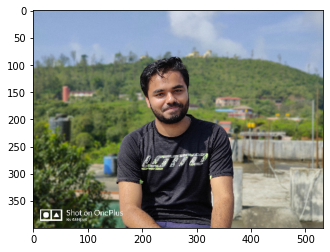

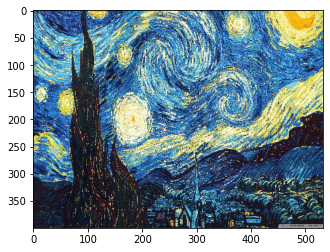

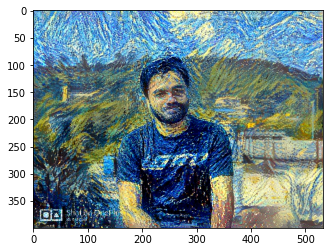

In [101]:
# results 
from matplotlib import pyplot as plt

# Content image
plt.imshow(load_img(target_image_path, target_size=(img_height, img_width)))
plt.figure()

# Style image
plt.imshow(load_img(style_reference_image_path, target_size=(img_height, img_width)))
plt.figure()

# Generate image
plt.imshow(img)
plt.show()

In [ ]:
!rm *.png